In [42]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import numpy as np
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

In [43]:
data = pd.read_excel(r'C:\Users\mbauer2\workspace\Uni\enterprise-ai-project\ImmmoWelt_Price_Guide\houses_to_buy_nbg_preprocessed.xlsx')

In [44]:
data.replace('""', np.nan, inplace=True)

In [45]:
data['DistributionType'].unique()

array(['BUY', 'COMPULSORY_AUCTION', 'BUY_AUCTION'], dtype=object)

In [156]:
data = data[data['DistributionType']=='BUY']

In [46]:
data = data[data['EstateType']=='HOUSE']

In [47]:
data

,Unnamed: 0,Object_price,LivingSpace,Rooms,ConstructionYear,ContactData,ZipCode,EstateType,DistributionType,abrissobjekt,...,tiefgarage,unterkellert,vermietet,vollerschlossen,wachdienst,wanne,wasch_trockenraum,wg_geeignet,wintergarten,zentralheizung
1,1,913800,163.00,7.0,2021.0,"{""companyName"": ""Lechner Massivhaus GmbH"", ""ad...",90455,HOUSE,BUY,0,...,0,1,0,0,0,1,0,0,0,0
2,2,850000,124.00,5.0,2021.0,"{""companyName"": ""Lechner Massivhaus GmbH"", ""ad...",90455,HOUSE,BUY,0,...,0,1,0,0,0,1,0,0,0,0
4,4,890600,163.00,7.0,2021.0,"{""companyName"": ""Lechner Massivhaus GmbH"", ""ad...",90455,HOUSE,BUY,0,...,0,1,0,0,0,1,0,0,0,0
6,6,860000,200.00,13.0,1970.0,"{""companyName"": ""Immobilien Brewer"", ""address""...",90427,HOUSE,BUY,0,...,0,0,0,0,0,0,0,0,0,1
7,7,559000,157.56,5.0,1973.0,"{""companyName"": ""Angerm\u00fcller Immobilien M...",90473,HOUSE,BUY,0,...,0,1,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,381,1400000,178.00,7.0,1978.0,"{""companyName"": ""FALCON Immobilien"", ""address""...",90475,HOUSE,BUY,0,...,0,0,0,0,0,0,0,0,0,1
382,382,1390000,184.00,15.0,NaN,"{""companyName"": ""EURAG GmbH"", ""address"": {""cit...",90431,HOUSE,BUY,0,...,0,0,0,0,0,0,0,0,0,0
383,383,695000,118.00,4.0,1958.0,"{""companyName"": ""L\u00f6w Immobilien GmbH"", ""a...",90455,HOUSE,BUY,0,...,0,1,0,0,0,0,0,0,0,0
384,384,4000000,522.40,35.0,2023.0,"{""companyName"": ""MGDN GmbH"", ""address"": {""city...",90475,HOUSE,BUY,0,...,0,1,0,0,0,0,0,0,0,0


In [48]:
data['ConstructionYear'].isnull().sum()
print(data.isnull().sum())

Unnamed: 0            0
Object_price          0
LivingSpace           0
Rooms                 0
ConstructionYear     33
                     ..
wanne                 0
wasch_trockenraum     0
wg_geeignet           0
wintergarten          0
zentralheizung        0
Length: 113, dtype: int64


In [49]:
data.dropna(inplace=True)
data["LivingSpace"] = pd.to_numeric(data["LivingSpace"], errors="coerce")
data["Rooms"] = pd.to_numeric(data["Rooms"], errors="coerce")
data.dropna(subset=['ConstructionYear'], inplace=True)
data.dropna(subset=['Object_price'], inplace=True)
data.dropna(subset=['Rooms'], inplace=True)
data.dropna(subset=['LivingSpace'], inplace=True)
data.drop('ContactData', axis=1, inplace=True)
data.drop('Unnamed: 0', axis=1, inplace=True)
#data.drop('Object_currency', axis=1, inplace=True)
#data.drop('Url', axis=1, inplace=True)
#data.drop('EstateType', axis=1, inplace=True)
#data.drop('DistributionType', axis=1, inplace=True)
data['ZipCode']= data['ZipCode'].astype(str)
data['LivingSpace']= data['LivingSpace'].astype(float)
data = data.reindex()

In [50]:
data

,Object_price,LivingSpace,Rooms,ConstructionYear,ZipCode,EstateType,DistributionType,abrissobjekt,abstellraum,alarmanlage,...,tiefgarage,unterkellert,vermietet,vollerschlossen,wachdienst,wanne,wasch_trockenraum,wg_geeignet,wintergarten,zentralheizung
1,913800,163.00,7.0,2021.0,90455,HOUSE,BUY,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2,850000,124.00,5.0,2021.0,90455,HOUSE,BUY,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,890600,163.00,7.0,2021.0,90455,HOUSE,BUY,0,0,0,...,0,1,0,0,0,1,0,0,0,0
6,860000,200.00,13.0,1970.0,90427,HOUSE,BUY,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,559000,157.56,5.0,1973.0,90473,HOUSE,BUY,0,1,0,...,0,1,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,475000,120.00,5.0,1966.0,90469,HOUSE,BUY,0,0,0,...,0,1,0,0,0,1,1,0,0,1
381,1400000,178.00,7.0,1978.0,90475,HOUSE,BUY,0,0,0,...,0,0,0,0,0,0,0,0,0,1
383,695000,118.00,4.0,1958.0,90455,HOUSE,BUY,0,1,0,...,0,1,0,0,0,0,0,0,0,0
384,4000000,522.40,35.0,2023.0,90475,HOUSE,BUY,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [51]:
print(data.isnull().sum())

Object_price         0
LivingSpace          0
Rooms                0
ConstructionYear     0
ZipCode              0
                    ..
wanne                0
wasch_trockenraum    0
wg_geeignet          0
wintergarten         0
zentralheizung       0
Length: 111, dtype: int64


In [52]:
data = data.reset_index(drop=True)

In [53]:
data

,Object_price,LivingSpace,Rooms,ConstructionYear,ZipCode,EstateType,DistributionType,abrissobjekt,abstellraum,alarmanlage,...,tiefgarage,unterkellert,vermietet,vollerschlossen,wachdienst,wanne,wasch_trockenraum,wg_geeignet,wintergarten,zentralheizung
0,913800,163.00,7.0,2021.0,90455,HOUSE,BUY,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,850000,124.00,5.0,2021.0,90455,HOUSE,BUY,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2,890600,163.00,7.0,2021.0,90455,HOUSE,BUY,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,860000,200.00,13.0,1970.0,90427,HOUSE,BUY,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,559000,157.56,5.0,1973.0,90473,HOUSE,BUY,0,1,0,...,0,1,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,475000,120.00,5.0,1966.0,90469,HOUSE,BUY,0,0,0,...,0,1,0,0,0,1,1,0,0,1
330,1400000,178.00,7.0,1978.0,90475,HOUSE,BUY,0,0,0,...,0,0,0,0,0,0,0,0,0,1
331,695000,118.00,4.0,1958.0,90455,HOUSE,BUY,0,1,0,...,0,1,0,0,0,0,0,0,0,0
332,4000000,522.40,35.0,2023.0,90475,HOUSE,BUY,0,1,0,...,0,1,0,0,0,0,0,0,0,0


C:\Users\mbauer2\AppData\Local\Temp\ipykernel_4600\1150594620.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), cmap="RdBu")


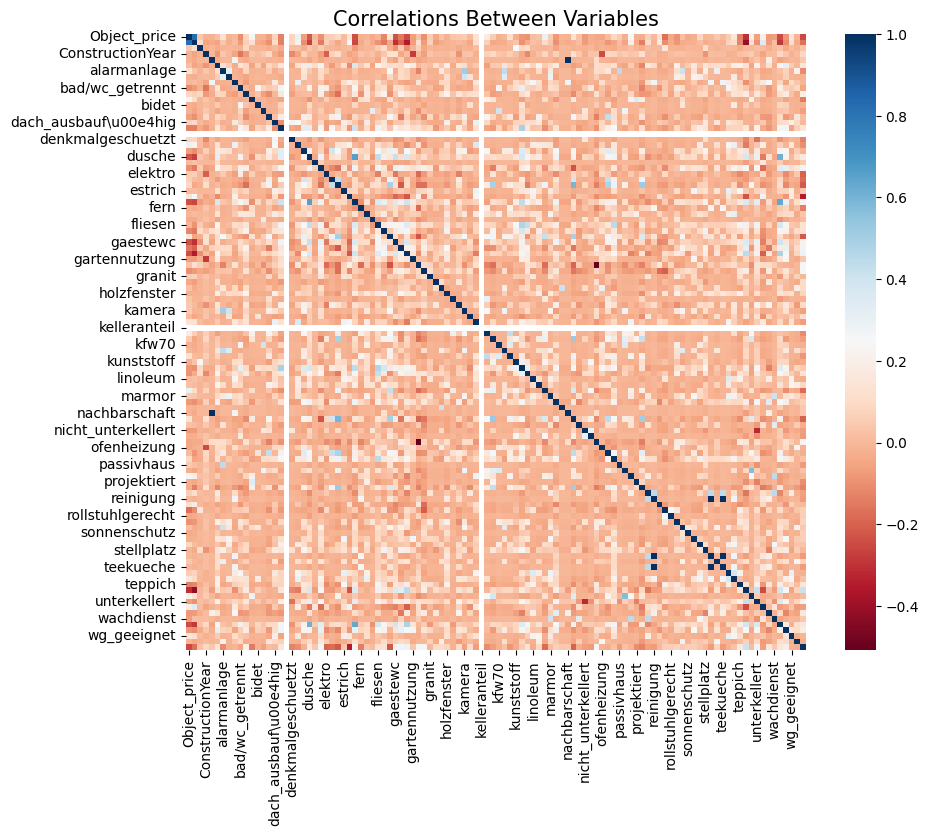

In [54]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), cmap="RdBu")
plt.title("Correlations Between Variables", size=15)
plt.show()

In [55]:
important_num_cols = list(data.corr()["Object_price"][(data.corr()["Object_price"]>0.20) | (data.corr()["Object_price"]<-0.20)].index)

C:\Users\mbauer2\AppData\Local\Temp\ipykernel_4600\847568539.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  important_num_cols = list(data.corr()["Object_price"][(data.corr()["Object_price"]>0.20) | (data.corr()["Object_price"]<-0.20)].index)


In [69]:
cat_cols = [col for col in data.columns if data[col].dtype == 'object']
cat_cols

['ZipCode', 'EstateType', 'DistributionType']

In [70]:
important_cols = important_num_cols + cat_cols

data = data[important_cols]

In [72]:
important_num_cols

['Object_price',
 'LivingSpace',
 'barriefrei',
 'dielen',
 'dusche',
 'fenster',
 'gaestewc',
 'garten',
 'luftwp',
 'personenaufzug',
 'terrasse',
 'tiefgarage',
 'wanne',
 'zentralheizung']

In [112]:
y = data['Object_price']
X = data.drop('Object_price', axis=1)
print(y.head())
print(X.head())

0    913800
1    850000
2    890600
3    860000
4    559000
Name: Object_price, dtype: int64
   LivingSpace  barriefrei  dielen  dusche  fenster  gaestewc  garten  luftwp  \
0       163.00           0       0       1        1         1       1       1   
1       124.00           0       0       1        1         1       1       1   
2       163.00           0       0       1        1         1       1       1   
3       200.00           0       0       0        0         0       0       0   
4       157.56           0       0       1        1         1       1       0   

   personenaufzug  terrasse  tiefgarage  wanne  zentralheizung ZipCode  \
0               0         1           0      1               0   90455   
1               0         1           0      1               0   90455   
2               0         1           0      1               0   90455   
3               0         0           0      0               1   90427   
4               0         1           0      1    

In [113]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 42)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, 
                                                  train_size=0.8, 
                                                  random_state = 42)

In [114]:
num_cols = [col for col in train_X.columns if train_X[col].dtype == 'float64']
cat_cols = [col for col in train_X.columns if train_X[col].dtype == 'object']
bin_cols = [col for col in train_X.columns if train_X[col].dtype == 'int64']

In [115]:
num_cols

['LivingSpace']

In [116]:
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_xgb = encoder.fit_transform(train_X[cat_cols]).toarray()
X_valid_categorical_xgb = encoder.transform(val_X[cat_cols]).toarray()
X_test_categorical_xgb = encoder.transform(test_X[cat_cols]).toarray()
X_train_processed = np.concatenate([train_X[num_cols], X_train_categorical_xgb], axis=1)
X_valid_processed = np.concatenate([val_X[num_cols], X_valid_categorical_xgb], axis=1)
X_test_processed = np.concatenate([test_X[num_cols], X_test_categorical_xgb], axis=1)
X_train_processed = np.concatenate([train_X[bin_cols], X_train_processed], axis=1)
X_valid_processed = np.concatenate([val_X[bin_cols], X_valid_processed], axis=1)
X_test_processed = np.concatenate([test_X[bin_cols], X_test_processed], axis=1)

In [117]:
X_train_processed[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 86.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  1.,  0.])

In [118]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 42)
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_xgb = encoder.fit_transform(train_X[cat_cols]).toarray()
X_test_categorical_xgb = encoder.transform(test_X[cat_cols]).toarray()
X_train_processed = np.concatenate([train_X[num_cols], X_train_categorical_xgb], axis=1)
X_test_processed = np.concatenate([test_X[num_cols], X_test_categorical_xgb], axis=1)
X_train_processed = np.concatenate([train_X[bin_cols], X_train_processed], axis=1)
X_test_processed = np.concatenate([test_X[bin_cols], X_test_processed], axis=1)
train_X.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)
k = 10  
kf = KFold(n_splits=k, random_state=42, shuffle=True)
fold_scores = []
model = xgb.XGBRegressor(eval_metric=['rmse', 'mae'], early_stopping_rounds=30)
for train_index, val_index in kf.split(X_train_processed):
    fold_train_X, fold_val_X = X_train_processed[train_index], X_train_processed[val_index]
    fold_train_y, fold_val_y = train_y[train_index], train_y[val_index]
    model.fit(X=fold_train_X, y=fold_train_y, eval_set=[(fold_val_X, fold_val_y)], verbose=True)
    fold_preds = model.predict(fold_val_X)
    fold_score = mean_absolute_error(fold_val_y, fold_preds)
    fold_scores.append(fold_score)

# Durchschnittliche Bewertung über alle Folds
average_score = np.mean(fold_scores)
print("Durchschnittlicher MAE über 10 Folds:", average_score)

# Modellvorhersage für Testdaten
test_preds = model.predict(X_test_processed)

# Bewertung auf Testdaten
test_score = mean_absolute_error(test_y, test_preds)
print("MAE auf Testdaten:", test_score)

[0]	validation_0-rmse:1134747.03776	validation_0-mae:697214.30324
[1]	validation_0-rmse:924148.94104	validation_0-mae:488132.47338
[2]	validation_0-rmse:774954.18994	validation_0-mae:374805.72917
[3]	validation_0-rmse:670574.58024	validation_0-mae:307857.28241
[4]	validation_0-rmse:599825.05855	validation_0-mae:270126.68056
[5]	validation_0-rmse:549149.95893	validation_0-mae:251506.26157
[6]	validation_0-rmse:517422.20537	validation_0-mae:243548.57870
[7]	validation_0-rmse:505211.47481	validation_0-mae:252590.94676
[8]	validation_0-rmse:491707.74384	validation_0-mae:250508.16782
[9]	validation_0-rmse:480296.36679	validation_0-mae:250095.61690
[10]	validation_0-rmse:469318.14383	validation_0-mae:247095.15625
[11]	validation_0-rmse:462537.50633	validation_0-mae:246992.78588


[12]	validation_0-rmse:457438.46774	validation_0-mae:246395.44907
[13]	validation_0-rmse:450916.56279	validation_0-mae:246291.03819
[14]	validation_0-rmse:453091.52760	validation_0-mae:251234.69444
[15]	validation_0-rmse:453245.61799	validation_0-mae:251038.56944
[16]	validation_0-rmse:449893.25894	validation_0-mae:250560.10417
[17]	validation_0-rmse:446217.00962	validation_0-mae:249121.95023
[18]	validation_0-rmse:446859.11165	validation_0-mae:250348.34722
[19]	validation_0-rmse:445132.08028	validation_0-mae:249750.93056
[20]	validation_0-rmse:445018.07469	validation_0-mae:249534.46528
[21]	validation_0-rmse:445540.09909	validation_0-mae:250513.13310
[22]	validation_0-rmse:446078.58035	validation_0-mae:251220.93750
[23]	validation_0-rmse:446589.08684	validation_0-mae:251424.54398
[24]	validation_0-rmse:444621.26633	validation_0-mae:250591.03356
[25]	validation_0-rmse:443367.79562	validation_0-mae:250129.10995
[26]	validation_0-rmse:443055.01271	validation_0-mae:250299.43403
[27]	valid

In [136]:

train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 42)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, 
                                                  train_size=0.8, 
                                                  random_state = 42)
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_xgb = encoder.fit_transform(train_X[cat_cols]).toarray()
X_valid_categorical_xgb = encoder.transform(val_X[cat_cols]).toarray()
X_test_categorical_xgb = encoder.transform(test_X[cat_cols]).toarray()
X_train_processed = np.concatenate([train_X[num_cols], X_train_categorical_xgb], axis=1)
X_valid_processed = np.concatenate([val_X[num_cols], X_valid_categorical_xgb], axis=1)
X_test_processed = np.concatenate([test_X[num_cols], X_test_categorical_xgb], axis=1)
X_train_processed = np.concatenate([train_X[bin_cols], X_train_processed], axis=1)
X_valid_processed = np.concatenate([val_X[bin_cols], X_valid_processed], axis=1)
X_test_processed = np.concatenate([test_X[bin_cols], X_test_processed], axis=1)
model = xgb.XGBRegressor(eval_metric=['rmse', 'mae'], early_stopping_rounds=30)
model.fit(X=X_train_processed, 
          y=train_y,
          eval_set=[(X_valid_processed, val_y)],  # Liste mit Validierungsdaten und Zielvariablen
          verbose=True
)

preds= model.predict(X_test_processed)
#preds_apartment = preds[test_X['EstateType']=='APARTMENT']
#test_y_apartment = test_y[test_X['EstateType']=='APARTMENT']
#preds_House = preds[test_X['EstateType']=='HOUSE']
#test_y_House= test_y[test_X['EstateType']=='HOUSE']
#score_House = mean_absolute_error(test_y_House, preds_House)
score_House = mean_absolute_error(test_y, preds)

print("MAE House: {}".format(score_House))
#

[0]	validation_0-rmse:942716.63974	validation_0-mae:625697.52604
[1]	validation_0-rmse:765015.06902	validation_0-mae:452438.65914
[2]	validation_0-rmse:646054.07281	validation_0-mae:359618.40394
[3]	validation_0-rmse:574184.53534	validation_0-mae:307059.02604
[4]	validation_0-rmse:529308.83055	validation_0-mae:285911.43750
[5]	validation_0-rmse:499171.53273	validation_0-mae:275669.33102
[6]	validation_0-rmse:478297.70732	validation_0-mae:268991.22454
[7]	validation_0-rmse:462241.60938	validation_0-mae:265429.68287
[8]	validation_0-rmse:459529.58737	validation_0-mae:269198.82755
[9]	validation_0-rmse:456034.61950	validation_0-mae:270505.26273
[10]	validation_0-rmse:452402.48550	validation_0-mae:270812.38368
[11]	validation_0-rmse:449450.30612	validation_0-mae:269652.39005
[12]	validation_0-rmse:446581.62279	validation_0-mae:269369.68634
[13]	validation_0-rmse:443923.56548	validation_0-mae:268751.75926
[14]	validation_0-rmse:445669.68349	validation_0-mae:269220.99074
[15]	validation_0-rm

[20]	validation_0-rmse:448063.50604	validation_0-mae:274847.31771
[21]	validation_0-rmse:450222.53753	validation_0-mae:276472.89062
[22]	validation_0-rmse:449908.64479	validation_0-mae:276206.16204
[23]	validation_0-rmse:450190.66217	validation_0-mae:276805.53009
[24]	validation_0-rmse:451219.71403	validation_0-mae:278258.91898
[25]	validation_0-rmse:450701.36852	validation_0-mae:278646.96991
[26]	validation_0-rmse:450458.72704	validation_0-mae:278655.70949
[27]	validation_0-rmse:449759.42219	validation_0-mae:277572.71296
[28]	validation_0-rmse:449871.68251	validation_0-mae:277897.00463
[29]	validation_0-rmse:450250.57663	validation_0-mae:279150.27257
[30]	validation_0-rmse:449862.94802	validation_0-mae:278255.87674
[31]	validation_0-rmse:450323.41796	validation_0-mae:278616.47396
[32]	validation_0-rmse:449883.60327	validation_0-mae:278663.97917
[33]	validation_0-rmse:450307.90317	validation_0-mae:279198.25868
[34]	validation_0-rmse:450519.56354	validation_0-mae:279261.63426
[35]	valid

In [137]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 42)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, 
                                                  train_size=0.8, 
                                                  random_state = 42)
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_xgb = encoder.fit_transform(train_X[cat_cols]).toarray()
X_valid_categorical_xgb = encoder.transform(val_X[cat_cols]).toarray()
X_test_categorical_xgb = encoder.transform(test_X[cat_cols]).toarray()
X_train_processed = np.concatenate([train_X[num_cols], X_train_categorical_xgb], axis=1)
X_valid_processed = np.concatenate([val_X[num_cols], X_valid_categorical_xgb], axis=1)
X_test_processed = np.concatenate([test_X[num_cols], X_test_categorical_xgb], axis=1)
X_train_processed = np.concatenate([train_X[bin_cols], X_train_processed], axis=1)
X_valid_processed = np.concatenate([val_X[bin_cols], X_valid_processed], axis=1)
X_test_processed = np.concatenate([test_X[bin_cols], X_test_processed], axis=1)
model2 = lgb.LGBMRegressor(metric=['rmse', 'mae'], early_stopping_rounds=30)
model2.fit(X=X_train_processed, 
          y=train_y,
          eval_set=[(X_valid_processed, val_y)], 
          verbose=True
)

preds= model2.predict(X_test_processed)
score = mean_absolute_error(test_y, preds)
print("MAE: {}".format(score))


[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[1]	valid_0's rmse: 784617	valid_0's l1: 445497
[2]	valid_0's rmse: 754683	valid_0's l1: 418693
[3]	valid_0's rmse: 728996	valid_0's l1: 394427
[4]	valid_0's rmse: 707269	valid_0's l1: 373164
[5]	valid_0's rmse: 686694	valid_0's l1: 351672
[6]	valid_0's rmse: 671695	valid_0's l1: 336027
[7]	valid_0's rmse: 656616	valid_0's l1: 324299
[8]	valid_0's rmse: 643971	valid_0's l1: 316309
[9]	valid_0's rmse: 633529	valid_0's l1: 310840
[10]	valid_0's rmse: 624655	valid_0's l1: 306330
[11]	valid_0's rmse: 618277	valid_0's l1: 302762
[12]	valid_0's rmse: 612527	valid_0's l1: 298844
[13]	valid_0's rmse: 607259	valid_0's l1: 295599
[14]	valid_0's rmse: 602871	valid_0's l1: 293596
[15]	valid_0's rmse: 598846	valid_0's l1: 290841
[16]	valid_0's rmse: 595447	valid_0's l1: 288342
[17]	valid_0's rmse: 592433	valid_0's l1: 285942
[18]	valid_0's rmse: 589964	valid_0's l1: 

c:\Python311\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


In [138]:

train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 42)
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_xgb = encoder.fit_transform(train_X[cat_cols]).toarray()
X_test_categorical_xgb = encoder.transform(test_X[cat_cols]).toarray()
X_train_processed = np.concatenate([train_X[num_cols], X_train_categorical_xgb], axis=1)
X_test_processed = np.concatenate([test_X[num_cols], X_test_categorical_xgb], axis=1)
X_train_processed = np.concatenate([train_X[bin_cols], X_train_processed], axis=1)
X_test_processed = np.concatenate([test_X[bin_cols], X_test_processed], axis=1)
train_X.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)
k = 10
kf = KFold(n_splits=k, random_state=42, shuffle=True)
fold_scores = []
model = lgb.LGBMRegressor(metric=['rmse', 'mae'], early_stopping_rounds=30)

for train_index, val_index in kf.split(X_train_processed):
    fold_train_X, fold_val_X = X_train_processed[train_index], X_train_processed[val_index]
    fold_train_y, fold_val_y = train_y[train_index], train_y[val_index]
    model.fit(X=fold_train_X, y=fold_train_y, eval_set=[(fold_val_X, fold_val_y)], verbose=True)
    fold_preds = model.predict(fold_val_X)
    fold_score = mean_absolute_error(fold_val_y, fold_preds)
    fold_scores.append(fold_score)


average_score = np.mean(fold_scores)
print("Durchschnittlicher MAE über 10 Folds:", average_score)

test_preds = model.predict(X_test_processed)

test_score = mean_absolute_error(test_y, test_preds)
print("MAE auf Testdaten:", test_score)

c:\Python311\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Python311\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Python311\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Python311\Lib\site-

[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[1]	valid_0's rmse: 989338	valid_0's l1: 472533
[2]	valid_0's rmse: 946593	valid_0's l1: 434968
[3]	valid_0's rmse: 909704	valid_0's l1: 400782
[4]	valid_0's rmse: 880784	valid_0's l1: 371918
[5]	valid_0's rmse: 853454	valid_0's l1: 349158
[6]	valid_0's rmse: 830227	valid_0's l1: 336343
[7]	valid_0's rmse: 811797	valid_0's l1: 323879
[8]	valid_0's rmse: 794736	valid_0's l1: 319218
[9]	valid_0's rmse: 779968	valid_0's l1: 313226
[10]	valid_0's rmse: 767844	valid_0's l1: 309677
[11]	valid_0's rmse: 758051	valid_0's l1: 303980
[12]	valid_0's rmse: 748515	valid_0's l1: 298768
[13]	valid_0's rmse: 740580	valid_0's l1: 295736
[14]	valid_0's rmse: 733859	valid_0's l1: 294374
[15]	valid_0's rmse: 728342	valid_0's l1: 293696
[16]	valid_0's rmse: 723586	valid_0's l1: 293195
[17]	valid_0's rmse: 719330	valid_0's l1: 291602
[18]	valid_0's rmse: 716029	valid_0's l1: 

c:\Python311\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Python311\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


In [139]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 42)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, 
                                                  train_size=0.8, 
                                                  random_state = 42)
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_xgb = encoder.fit_transform(train_X[cat_cols]).toarray()
X_valid_categorical_xgb = encoder.transform(val_X[cat_cols]).toarray()
X_test_categorical_xgb = encoder.transform(test_X[cat_cols]).toarray()
X_train_processed = np.concatenate([train_X[num_cols], X_train_categorical_xgb], axis=1)
X_valid_processed = np.concatenate([val_X[num_cols], X_valid_categorical_xgb], axis=1)
X_test_processed = np.concatenate([test_X[num_cols], X_test_categorical_xgb], axis=1)
X_train_processed = np.concatenate([train_X[bin_cols], X_train_processed], axis=1)
X_valid_processed = np.concatenate([val_X[bin_cols], X_valid_processed], axis=1)
X_test_processed = np.concatenate([test_X[bin_cols], X_test_processed], axis=1)
n_estimators = [10, 50, 100, 200, 300, 400, 500]
train_maes = []
valid_maes = []
for n in n_estimators:
    
    rf_model = RandomForestRegressor(n_estimators=n, random_state=0)
    rf_model.fit(X_train_processed, train_y)

    
    preds_train_rf = rf_model.predict(X_train_processed)
    preds_valid_rf = rf_model.predict(X_valid_processed)

    
    train_mae = mean_absolute_error(train_y, preds_train_rf)
    valid_mae = mean_absolute_error(val_y, preds_valid_rf)

    
    train_maes.append(train_mae)
    valid_maes.append(valid_mae)

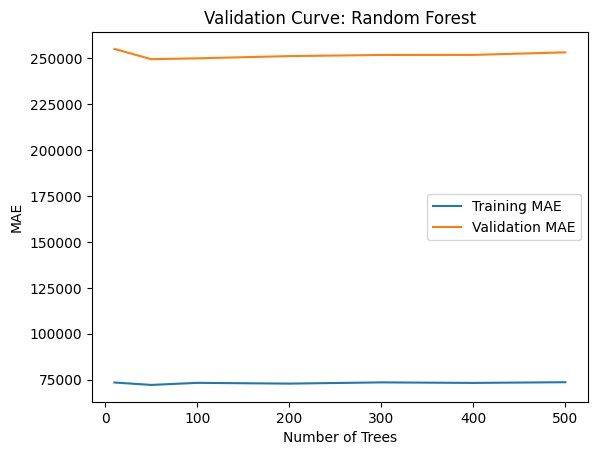

In [140]:
plt.plot(n_estimators, train_maes, label='Training MAE')
plt.plot(n_estimators, valid_maes, label='Validation MAE')
plt.xlabel('Number of Trees')
plt.ylabel('MAE')
plt.legend()
plt.title('Validation Curve: Random Forest')
plt.show()

In [143]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 42)

encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_xgb = encoder.fit_transform(train_X[cat_cols]).toarray()
X_test_categorical_xgb = encoder.transform(test_X[cat_cols]).toarray()
X_train_processed = np.concatenate([train_X[num_cols], X_train_categorical_xgb], axis=1)
X_test_processed = np.concatenate([test_X[num_cols], X_test_categorical_xgb], axis=1)
X_train_processed = np.concatenate([train_X[bin_cols], X_train_processed], axis=1)
X_test_processed = np.concatenate([test_X[bin_cols], X_test_processed], axis=1)
train_X.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
rf_model.fit(X_train_processed, train_y)
preds_test_rf = rf_model.predict(X_test_processed)
score = mean_absolute_error(test_y, preds_test_rf)
print("MAE: {}".format(score))

MAE: 237270.7562189055


In [144]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 42)

encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_xgb = encoder.fit_transform(train_X[cat_cols]).toarray()
X_test_categorical_xgb = encoder.transform(test_X[cat_cols]).toarray()
X_train_processed = np.concatenate([train_X[num_cols], X_train_categorical_xgb], axis=1)
X_test_processed = np.concatenate([test_X[num_cols], X_test_categorical_xgb], axis=1)
X_train_processed = np.concatenate([train_X[bin_cols], X_train_processed], axis=1)
X_test_processed = np.concatenate([test_X[bin_cols], X_test_processed], axis=1)
train_X.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)
k = 10  
kf = KFold(n_splits=k, random_state=42, shuffle=True)
fold_scores = []
model = RandomForestRegressor(n_estimators=100, random_state=0)

for train_index, val_index in kf.split(X_train_processed):
    fold_train_X, fold_val_X = X_train_processed[train_index], X_train_processed[val_index]
    fold_train_y, fold_val_y = train_y[train_index], train_y[val_index]
    model.fit(X=fold_train_X, y=fold_train_y)
    fold_preds = model.predict(fold_val_X)
    fold_score = mean_absolute_error(fold_val_y, fold_preds)
    fold_scores.append(fold_score)
average_score = np.mean(fold_scores)
print("Durchschnittlicher MAE über 10 Folds:", average_score)
test_preds = model.predict(X_test_processed)
test_score = mean_absolute_error(test_y, test_preds)
print("MAE auf Testdaten:", test_score)

Durchschnittlicher MAE über 10 Folds: 219593.1497388414
MAE auf Testdaten: 232625.70572139302
